* Analysis elgRate correlation to position 
  * 250328-frame 60 (2h, G4) to max frame on elgRate , step per 10frame
  * TODO: need to replot 
* color cells based on their orientations

In [1]:
# import the essential packages 
import numpy as np   # for numerics
import glob   #for parsing directories and files
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt  #for plotting
import random
import cv2
from PIL import Image
import os
from matplotlib import cm
import json
import pickle
import pandas as pd

import scipy.stats

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [2]:
""" 
Analysis and plot elgRate correlation to position 

----input---
-area-xy.csv  frame, x,y
-tracks-cv2.csv frame, x,y
-elg-cv2.csv [cell_ID, elgRate_b] 
 from [cell_ID, generation, time_start, mean_solidity, Lb, Ld, elgRate_b, ..., division_time]
 
----output----
-corr_elg_dist.csv
[frame,cell_ID,dist,elgRate,Lb,division_time,mean_solidity]
test scatter plot of elgRate, with Pearson correlation printed

"""
scale100 = 0.0639  # um per pixel
exppath = 'ForPub/300-LBLMagar/'
rplcpathList = [f.path for f in os.scandir(exppath) if f.is_dir() and '00' in f.name]
# rplcpathList =['ForPub/075-LBLMagar/00823']

# col_name = "elgRate_b", "Lb", "division_time"
for rplcpath in sorted(rplcpathList):
    head, rplcIdx = os.path.split(rplcpath)
    print(rplcIdx)
    plotpath = rplcpath + '/ana-correlation'
    if not os.path.exists(plotpath):
        os.makedirs(plotpath)

    areaName = rplcIdx + '-area-xy.csv' # area of colony and colony contour
    areapath = os.path.join(rplcpath, areaName)
    tracksName = rplcIdx + "-tracks-cv2.csv" 
    trackspath = os.path.join(rplcpath, tracksName)
    elgName = rplcIdx + "-elg-cv2.csv"
    elgpath = os.path.join(rplcpath, elgName)
    outName = rplcIdx + "-corr_elg_dist.csv"
    
    area_df = pd.read_csv(areapath, header=0, usecols=["frame", "x", "y"])
    tracks_df = pd.read_csv(trackspath, header=0, usecols=["cell_ID", "frame", "x", "y"])
    elg_df = pd.read_csv(elgpath, header=0, 
                         usecols=["cell_ID", "elgRate_b", "Lb", "division_time", "time_start", "mean_solidity"])
    
    max_frame = int(np.rint(0.5* elg_df["time_start"].max()) +1)
    # empty list
    out_results =[]
#     out_df = pd.DataFrame(columns=["frame", "cell_ID", "dist", "elgRate", "mean_solidity"])
    for f in range(60, max_frame, 10):
        area_data = area_df.loc[area_df["frame"]==f, ["x", "y"]]
        if area_data.empty:
            mtmt_frame = area_df["frame"].max()
            cntx, cnty = area_df.loc[area_df["frame"] == mtmt_frame, ["x", "y"]].iloc[0].values
        else:
            # If data found for the given frame, use that
            cntx, cnty = area_data.iloc[0].values           
#         cntx, cnty = area_df.loc[area_df["frame"]==f, ["x", "y"]].iloc[0].values
#         print(f, cntx, cnty)
        frame_cells = tracks_df.loc[tracks_df["frame"]==f, ["cell_ID", "x", "y"]]
        
        results =[]        
        for _, row in frame_cells.iterrows():
            cell_ID, x, y = row["cell_ID"], row["x"], row["y"]
            dist = np.sqrt((x - cntx) ** 2 + (y - cnty) ** 2) *scale100  # in um
            
            elg_data = elg_df.loc[elg_df["cell_ID"]==cell_ID, ["elgRate_b", "Lb", "division_time", "mean_solidity"]]
            if elg_data.empty:
                continue
            else:
                elgRate, Lb, div, solidity = elg_data.iloc[0].values
            results.append([f, cell_ID, dist, elgRate, Lb, div, solidity])
            results_df = pd.DataFrame(results, columns=["frame", "cell_ID", "dist", "elgRate", "Lb", "division_time", "mean_solidity"])
            
        # filter with mean_solidity >0.7
        results_filter = results_df.loc[results_df["mean_solidity"] > 0.7]
        # analyze correlation 
        corr, p_value = scipy.stats.pearsonr(results_df["dist"], results_df["elgRate"])
        corr_f, p_value_f = scipy.stats.pearsonr(results_filter["dist"], results_filter["elgRate"])
        print(f, corr, p_value, corr_f, p_value_f)
        # plot scatter
        fig,ax = plt.subplots()
        ax.scatter(results_df["dist"], results_df["Lb"], color="r", marker="o")
        ax.scatter(results_filter["dist"], results_filter["Lb"], color="k", marker="o")
        ax.set_xlabel("Distance to center (um)")
        ax.set_ylabel("Elongation rate (/min)")
        text = f"frame {f:d}: \n PearsonC: {corr:.3f}, p-value: {p_value:.3f} \n filtered PearsonC: {corr_f:.3f}, p-value: {p_value_f:.3f}"
        ax.text(0.02, 0.98, text, ha='left', va='top', transform=ax.transAxes)
        plt.savefig(os.path.join(plotpath, f"elgRate-corr-frame{f:d}.png"), dpi=300)
        plt.close(fig)
        
#         out_df = pd.concat([out_df, results_df], ignore_index=True)
        out_results.extend(results)

    out_df = pd.DataFrame(out_results, columns=["frame", "cell_ID", "dist", "elgRate", "Lb", "division_time", "mean_solidity"])
    out_df.to_csv(os.path.join(rplcpath, outName), index=False)


00753
60 -0.8180194622201367 0.007049821731820478 -0.8180194622201367 0.007049821731820478
70 -0.6645228329720436 0.0049836403900623385 -0.6645228329720436 0.0049836403900623385
80 -0.6219612210600718 0.00024331157986792995 -0.6219612210600718 0.00024331157986792995
90 -0.46007667517036044 0.002172513312286338 -0.46007667517036044 0.002172513312286338
100 -0.30815887762302935 0.012512563129202063 -0.30815887762302935 0.012512563129202063
110 -0.34816659223774915 0.00027316625571581054 -0.34816659223774915 0.00027316625571581054
120 -0.4645272483193371 3.0893775363900574e-09 -0.4645272483193371 3.0893775363900574e-09
130 -0.1448327343842748 0.02545668998941696 -0.1448327343842748 0.02545668998941696
00766
60 -0.7231785876551822 0.003468492448422886 -0.7231785876551822 0.003468492448422886
70 -0.6498165277065777 0.006435690220584764 -0.6498165277065777 0.006435690220584764
80 -0.3839406322087796 0.04802652985352385 -0.3839406322087796 0.04802652985352385
90 -0.35412322032976745 0.0170053

00753
130 -0.029014845812173555 0.6560622280339685
120 -0.08376396159964367 0.31312423092588926
110 -0.22735625857592787 0.019676803988530705
100 -0.011712879763637355 0.9262188754598193
90 -0.020111411284819504 0.8994025326460707
80 0.23432730508551666 0.212629164968078
70 0.32521660886214365 0.2190347596596451
60 -0.04075255015934173 0.9170943988900606
00766
130 -0.03492080498294871 0.6031463203943799
120 -0.08943054630515483 0.26846355299934044
110 0.06785185523059586 0.48741749411709623
100 0.19299592729440182 0.1296535371273469
90 0.2226134029398609 0.1416081862221851
80 0.385970381157197 0.04675901506260146
70 0.2737679520827928 0.3048846302102711
60 0.024856074796124193 0.9327830625000335
00772-2
120 0.10784294236268756 0.153072712208973
110 0.2339903939548701 0.016286160193450312
100 0.3829019866262094 0.0010696145116079608
90 0.17943785303909218 0.26161943391893555
80 0.13673698267649131 0.5240499755989293
70 0.4162554379738734 0.1387535236330479
60 0.10916332471260552 0.79693

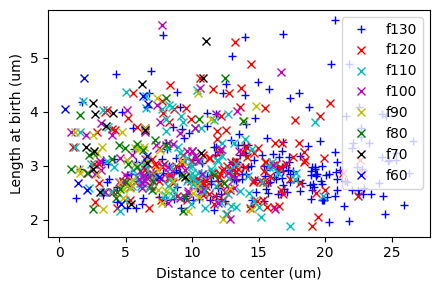

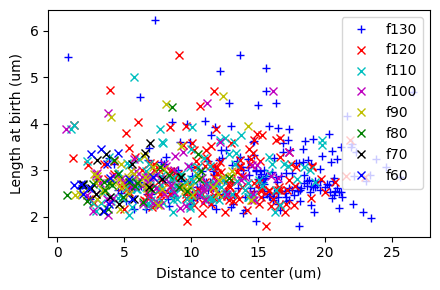

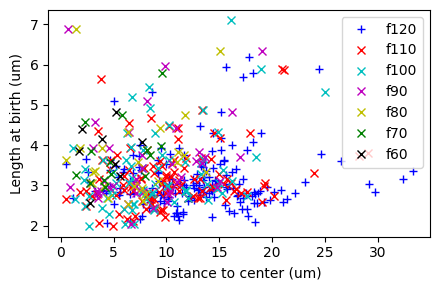

In [4]:
"""
plot elgRate correlation to position (distance to the center, converted to um)

----input----
-corr_elg_dist.csv
[frame,cell_ID,dist,elgRate,Lb,division_time,mean_solidity]
----output----
scatter plot, with Pearson correlation printed
"""

ms = ['b+', 'rx', 'cx', 'mx', 'yx', 'gx', 'kx', "bx"]
col_name = "Lb"  #  "elgRate", "Lb", "division_time"

exppath = 'ForPub/300-LBLMagar/'
rplcpathList = [f.path for f in os.scandir(exppath) if f.is_dir() and '00' in f.name]
# rplcpathList =['ForPub/075-LBLMagar/00823']

for rplcpath in sorted(rplcpathList):
    head, rplcIdx = os.path.split(rplcpath)
    print(rplcIdx)
    plotpath = rplcpath + '/ana-correlation'
    plotName = rplcIdx + col_name + "-dist-corr.png"
    corrName = rplcIdx + "-corr_elg_dist.csv"
    corr_df = pd.read_csv(os.path.join(rplcpath, corrName), header=0)
    
    fig,ax = plt.subplots(figsize=[4.5,3])
    # break corr_df into blocks, late frames processed first
    for i, frame in enumerate(sorted(corr_df["frame"].unique(), reverse=True)):
        results = corr_df[corr_df["frame"] == frame]  # Select the corresponding group
        # for "elgRate" and "Lb", filter with mean_solidity >0.7 
        results = results.loc[results["mean_solidity"] > 0.7]
        
        # filter outliers 
        results_mean = results[col_name].mean()
        std_dev = results[col_name].std()
        z_scores = np.abs((results[col_name] - results_mean)) / std_dev
        results_filtered = results[np.abs(z_scores) < 5]
        # analyze correlation 
        corr, p_value = scipy.stats.pearsonr(results_filtered["dist"], results_filtered[col_name])
        print(frame, corr, p_value)
        # plot scatter    
        ax.plot(results_filtered["dist"], results_filtered[col_name], ms[i], label=f"f{frame}")

    ax.set_xlabel("Distance to center (um)")
    ax.set_ylabel("Length at birth (um)")  # Elongation Rate (/min) Length at birth (um) Division time (min)
    ax.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(plotpath, plotName), dpi=300)


00753
130 -0.029014845812173555 0.6560622280339685
120 -0.08376396159964367 0.31312423092588926
110 -0.22735625857592787 0.019676803988530705
100 -0.011712879763637355 0.9262188754598193
90 -0.020111411284819504 0.8994025326460707
80 0.23432730508551666 0.212629164968078
70 0.32521660886214365 0.2190347596596451
60 -0.04075255015934173 0.9170943988900606
00766
130 -0.03492080498294871 0.6031463203943799
120 -0.08943054630515483 0.26846355299934044
110 0.06785185523059586 0.48741749411709623
100 0.19299592729440182 0.1296535371273469
90 0.2226134029398609 0.1416081862221851
80 0.385970381157197 0.04675901506260146
70 0.2737679520827928 0.3048846302102711
60 0.024856074796124193 0.9327830625000335
00772-2
120 0.10784294236268756 0.153072712208973
110 0.2339903939548701 0.016286160193450312
100 0.3829019866262094 0.0010696145116079608
90 0.17943785303909218 0.26161943391893555
80 0.13673698267649131 0.5240499755989293
70 0.4162554379738734 0.1387535236330479
60 0.10916332471260552 0.79693

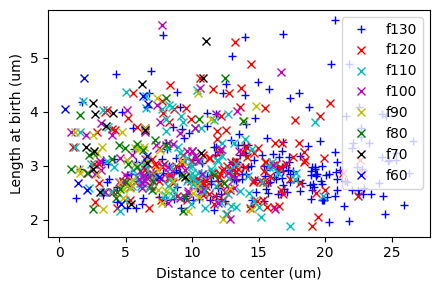

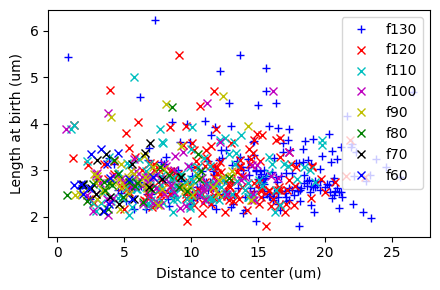

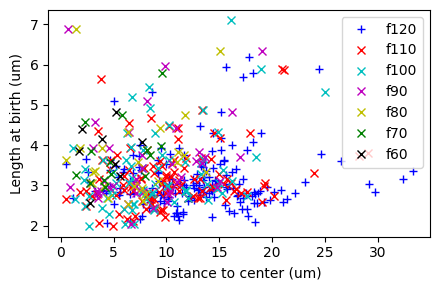

In [4]:
"""
plot only the negative corrs
elgRate correlation to position (distance to the center, converted to um)

----input----
-corr_elg_dist.csv
[frame,cell_ID,dist,elgRate,Lb,division_time,mean_solidity]
----output----
scatter plot, with Pearson correlation printed
"""

ms = ['b+', 'rx', 'cx', 'mx', 'yx', 'gx', 'kx', "bx"]
col_name = "Lb"  #  "elgRate", "Lb", "division_time"

exppath = 'ForPub/300-LBLMagar/'
rplcpathList = [f.path for f in os.scandir(exppath) if f.is_dir() and '00' in f.name]
# rplcpathList =['ForPub/075-LBLMagar/00823']

for rplcpath in sorted(rplcpathList):
    head, rplcIdx = os.path.split(rplcpath)
    print(rplcIdx)
    plotpath = rplcpath + '/ana-correlation'
    plotName = rplcIdx + col_name + "-dist-corr.png"
    corrName = rplcIdx + "-corr_elg_dist.csv"
    corr_df = pd.read_csv(os.path.join(rplcpath, corrName), header=0)
    
    fig,ax = plt.subplots(figsize=[4.5,3])
    # break corr_df into blocks, late frames processed first
    for i, frame in enumerate(sorted(corr_df["frame"].unique(), reverse=True)):
        results = corr_df[corr_df["frame"] == frame]  # Select the corresponding group
        # for "elgRate" and "Lb", filter with mean_solidity >0.7 
        results = results.loc[results["mean_solidity"] > 0.7]
        
        # filter outliers 
        results_mean = results[col_name].mean()
        std_dev = results[col_name].std()
        z_scores = np.abs((results[col_name] - results_mean)) / std_dev
        results_filtered = results[np.abs(z_scores) < 5]
        # analyze correlation 
#         corr, p_value = scipy.stats.pearsonr(results_filtered["dist"], results_filtered[col_name])
#         print(frame, corr, p_value)
        # plot scatter    
        ax.plot(results_filtered["dist"], results_filtered[col_name], ms[i], label=f"f{frame}")

    ax.set_xlabel("Distance to center (um)")
    ax.set_ylabel("Length at birth (um)")  # Elongation Rate (/min) Length at birth (um) Division time (min)
    ax.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(plotpath, plotName), dpi=300)


In [8]:
"""
plot elgRate correlation to position (distance to the center, converted to um)

----input----
-corr_elg_dist.csv
[frame,cell_ID,dist,elgRate,Lb,division_time,mean_solidity]
----output----
scatter plot, with Pearson correlation printed
"""
ms = ['b+', 'rx', 'cx', 'mx', 'yx', 'gx', 'kx', "bx"]
col_name =  "elgRate"  #  "elgRate", "Lb", "division_time"


pathDict = {'075': ['241219-075-ana/00738', 
                    '250116-075-ana/00814', 
                    '250117-075-2-ana/00823'],
            '150': ['250107-150-1-ana/00778', 
                   '250108-150-ana/00788'],
            '300': ['241220-3-ana/00753', 
                   '250102-3-ana/00766',
                   '250103-3-2-ana/00772-2'],
            '600': ['241218-6-ana/00734-2',
                   '250115-6-1-ana/00798-2']
}
for k in range(4):
    c = list(pathDict.keys())[k]  # '075'
    paths = pathDict[c]  # path list, used also as col_name in merged dataframe
#     rplcIdx_list = []
    for j in range(len(paths)):
        path = paths[j]
        rplcpath = os.path.join('ForPub', f"{c}-LBLMagar", path)
        head, rplcIdx = os.path.split(rplcpath) 
        print(rplcIdx)
        plotpath = rplcpath + '/ana-correlation'
        plotName = rplcIdx + col_name + "-dist-corr.png"
        corrName = rplcIdx + "-corr_elg_dist.csv"
        corr_df = pd.read_csv(os.path.join(rplcpath, corrName), header=0)
        
#         fig,ax = plt.subplots(figsize=[4.5,3])
        # break corr_df into blocks, late frames processed first
        for i, frame in enumerate(sorted(corr_df["frame"].unique(), reverse=True)):
            results = corr_df[corr_df["frame"] == frame]  # Select the corresponding group
            # for "elgRate" and "Lb", filter with mean_solidity >0.7 
            results = results.loc[results["mean_solidity"] > 0.7]

            # filter outliers 
            results_mean = results[col_name].mean()
            std_dev = results[col_name].std()
            z_scores = np.abs((results[col_name] - results_mean)) / std_dev
            results_filtered = results[np.abs(z_scores) < 5]
            # analyze correlation 
            corr, p_value = scipy.stats.pearsonr(results_filtered["dist"], results_filtered[col_name])
            print(frame, corr, p_value)
            # plot scatter    
            fig,ax = plt.subplots(figsize=[4.5,3])
            ax.plot(results_filtered["dist"], results_filtered[col_name], ms[i], label=f"f{frame}")

            ax.set_xlabel("Distance to center (um)")
            ax.set_ylabel("Elongation Rate (/min)")  # Elongation Rate (/min) Length at birth (um) Division time (min)
            text = f"frame {frame:d}: \n PearsonC: {corr:.3f}, p-value: {p_value:.3f}"
            ax.text(0.98, 0.98, text, ha='right', va='top', transform=ax.transAxes)
            plt.tight_layout()
            plt.savefig(os.path.join(plotpath, f"elgRate-corr-frame{frame:d}.png"), dpi=300)
            plt.close(fig)
        

00738
70 -0.40870781005148155 0.14679494852322356
60 -0.2220775775987196 0.5116254918264163
00814
100 -0.4005395863690084 0.0024437383881445243
90 -0.45245999651519 0.0010982478132348383
80 -0.5538961364889612 0.001005692598289505
70 -0.7587952022418638 0.0004132926296281207
60 -0.7842351692350391 0.0015056340529511487
00823
120 0.2670615339816943 4.5866912730155925e-05
110 0.18043164102574683 0.03624651693125924
100 0.055353534041400795 0.6022697026010894
90 -0.4948729381354543 0.00010568633696818701
80 -0.4329768485740704 0.010535368358835132
70 -0.040912664526096584 0.8719492977030353
60 -0.385955914188418 0.19273019513633882
00778
120 -0.09990352898843907 0.2003176649227204
110 -0.0722858192067366 0.4488038587125322
100 -0.07950550810409639 0.5390433278872401
90 -0.12411349059014692 0.44544616685282284
80 -0.22972888864382265 0.25891351365276133
70 -0.28524256584382 0.302770403121053
60 -0.527757282677616 0.11690958049244977
00788
110 -0.03143721730544903 0.6769908886012356
100 -0.

In [6]:
"""
color cells based on their orientations

1. find orientation of each contour cv2.minAreaRect() or cv2.fitEllipse()
2. color contours based on orientation

---input---
"-BG_Simple Segmentation.tiff"

---output---
"plot-videos-cv2\-orientation.tif"

"""
pathDict = {'075': ['241219-075-ana/00738', 
                    '250116-075-ana/00814', 
                    '250117-075-2-ana/00823'],
            '150': ['250107-150-1-ana/00778', 
                   '250108-150-ana/00788'],
            '300': ['241220-3-ana/00753', 
                   '250102-3-ana/00766',
                   '250103-3-2-ana/00772-2'],
            '600': ['241218-6-ana/00734-2',
                   '250115-6-1-ana/00798-2']
}
for i in range(4):
    c = list(pathDict.keys())[i]  # '075'
    paths = pathDict[c]  # path list
    
    for j in range(len(paths)):
        path = paths[j]
        rplcpath = os.path.join('ForPub', f"{c}-LBLMagar", path)

#         rplcpath ='ForPub/300-LBLMagar/241220-3-ana/00753'
        head, rplcIdx = os.path.split(rplcpath)
        plotpath = rplcpath + '/plot-videos-cv2'
        segName = rplcIdx + '-BG_Simple Segmentation.tiff'
        segpath = os.path.join(rplcpath, segName)
        outName = rplcIdx + '-orientation.tif'
        outpath = os.path.join(plotpath, outName)

        frames = []
        frames_processed = []
        ret,frames = cv2.imreadmulti(mats=frames, filename=segpath, flags=cv2.IMREAD_GRAYSCALE)
        for frame_index, binary in enumerate(frames):
            contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            color_img = np.zeros((binary.shape[0], binary.shape[1], 3), dtype=np.uint8)

            for cnt in contours:
                # Skip tiny contours
                if cv2.contourArea(cnt) < 10:
                    continue

                # Option 1: Bounding Box Orientation !!!often mix by +90
        #         rect = cv2.minAreaRect(cnt)
        #         angle = rect[2]  # In degrees
        #         if angle < -45:
        #             angle += 90  # Normalize to [0, 90)

                # Option 2: Ellipse Fitting Orientation
                if len(cnt) >= 5:
                    ellipse = cv2.fitEllipse(cnt)
                    angle = ellipse[2]  # Ellipse orientation (major axis)

                angle = angle % 180
                # Map angle to hue (HSV: 0–179 in OpenCV)
                hue = int(angle / 180.0 * 179)
                color = cv2.cvtColor(np.uint8([[[hue, 255, 255]]]), cv2.COLOR_HSV2BGR)[0, 0]

                # Draw filled contour with the color
                cv2.drawContours(color_img, [cnt], -1, color.tolist(), thickness=cv2.FILLED)

            frames_processed.append(Image.fromarray(color_img))

        # Save the processed frames as a TIFF stack
        frames_processed[0].save(outpath, save_all=True, append_images=frames_processed[1:], compression="tiff_deflate")

In [5]:
"""color map shown as a circle"""

# Size of the output image
plotpath = 'ForPub/ForPub-plot/'
radius = 150
size = 2 * radius
center = (radius, radius)

# Initialize HSV image
hsv_img = np.zeros((size, size, 3), dtype=np.uint8)

# Fill HSV image based on angle from center
for y in range(size):
    for x in range(size):
        dx = x - center[0]
        dy = center[1] - y  # y-axis inverted
        dist = np.sqrt(dx**2 + dy**2)
        if dist <= radius:
            # Compute angle (0 to 180) with horizontal axis (nematic symmetry)
            angle_rad = np.arctan2(dy, dx)
            angle_deg = np.degrees(angle_rad)
            angle_deg = angle_deg % 180  # Nematic symmetry: 0–180

            # Map angle to hue (0–179)
            hue = int((angle_deg / 180.0) * 179)

            hsv_img[y, x] = [hue, 255, 255]

# Convert HSV to BGR
bgr_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)

# Optional: Draw lines every 30°
for theta in range(0, 180, 30):
    angle_rad = np.radians(theta)
    x_end = int(center[0] + radius * np.cos(angle_rad))
    y_end = int(center[1] - radius * np.sin(angle_rad))
    cv2.line(bgr_img, center, (x_end, y_end), (0, 0, 0), 1)
    label_x = int(center[0] + (radius + 10) * np.cos(angle_rad))
    label_y = int(center[1] - (radius + 10) * np.sin(angle_rad))
    cv2.putText(bgr_img, f'{theta}°', (label_x - 10, label_y), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)

# Show and save
cv2.imwrite(os.path.join(plotpath, "circular_colormap_nematic.png"), bgr_img)
# cv2.imshow("Circular Orientation Color Map", bgr_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

True